## **Task: Evading AI-Generated Text Detection**  

### **Objective**  
Your goal is to modify the generation process of the **gemma2-2b** model so that generated texts belong to the distribution of fake text detector scores corresponding to humans (i.e. fake text detector thinks that generated texts are actually real). You are given only test set of prompts, and you can't use it for training.

### **Provided Data**  
1. `test.csv` – Contains a `"prompt"` column with test prompts that will be fed into Gemma-2B.  
2. **Reference Chart** (`dist.png`) – Shows the detector’s confidence scores for:  
   - Human-written text.  
   - Baseline gemma2-2b outputs.
   - Chat-GPT outputs.

### **Constraints**  
- **Model Restriction**: Your texts must be generated by provided gemma2-2B. No other LLMs are permitted.
- **No training on test**: You can't train/fine-tune the model on the test set of prompts. 
- **No Prompt/Generation Changes**: The input prompts and generation parameters (e.g., top-k, temperature) are fixed.  
- **Fixed `infer` Function**: The submission pipeline is immutable; your solution must work within it.  
- **Reproducibility**: Solutions must be deterministic, i.e. identical inputs should produce identical detector-evading outputs.  

### **What is allowed**
- Finetuning gemma2-2B model for text generation, including tuning of adapters/prefix tuning (again, note: training on test set of prompts is forbidden. You might use prompts that you create by yourself.).
- You can use any pre-trained models to help you understand how to change weights/representations of gemma2-2B.

## Baseline

First, we login to HuggingFace and import required modules

You need to accept the agreement of [gemma2-2b](https://huggingface.co/google/gemma-2-2b)

In [ ]:
from huggingface_hub import login

login("hf_XXXXXXXXXXX")

In [ ]:
import sys
sys.path.append("src")

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import List
import matplotlib.pyplot as plt
from dataclasses import dataclass

import torch
from torch.utils.data import DataLoader

from dataset import FakeTextDataset
from detector import FakeTextDetector

As an example of pre-trained model that you can use for understanding how to change weights/representation of gemma, we can use SAE trained for this model. Let's install the package for it:

In [5]:
# !pip install sae_lens==4.4.5 -q


from sae_lens import SAE, HookedSAETransformer

Define config for gemma-2-2b. You can change any parameter here except `model_name`

In [6]:
@dataclass
class Config:
    # data params
    # data_path: str = "/kaggle/input/neoai-2025-deception-fake-text-detector"
    data_path = "data"
    test_dataset_name: str = "test.csv"
    num_workers: int = 1
    batch_size: int = 40
    output_submission_path: str = "submission.csv"

    # gemma params
    device_llm: str = "cuda:1"
    model_name = "google/gemma-2-2b"

    # sae params
    release: str = "gemma-scope-2b-pt-res-canonical"
    device_sae: str = "cuda:1"
    layers = [14, 15, 16, 17, 18]
    num_latents_k: int = 16

    # detector params
    device_detector: str = "cuda:1"

Now we initialize the models:

In [7]:
# Initialize Gemma model
model = HookedSAETransformer.from_pretrained(Config.model_name, local_files_only=False, device=Config.device_llm)
model.eval()

# Initialize detector model
detector = FakeTextDetector(device=Config.device_detector)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


Load HC3 dataset for solution

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/Kz3OP8eQq49ubw) -o data.zip
! unzip -qq data.zip
! mv gemma_steering_ioai/* ./
! rm -rf gemma_steering_ioai data.zip

# Solution

This solution identifies steering vectors in Sparse Autoencoder (SAE) latent spaces that distinguish human vs AI generated text, then modifies model behavior during inference. The approach has two core phases:

## Phase 1: Identifying Discriminative SAE Features
##### Objective: Find latent features that maximally differentiate human vs AI text

1. Load human/gpt text pairs using HC3 dataset

2. Tokenize text with Gemma-2-2b's tokenizer

3. Store SAE activations (features) per-layer

4. Train XGBoost classifier for each SAE features from layers

5. For each class (human/gpt), identify top ```k``` features

6. Store feature indices, max values and deltas (gpt_mean_activations - human_mean_activations)

In [8]:
from torch.utils.data import Dataset

from transformers import AutoTokenizer


class HC3(Dataset):
    def __init__(
        self,
        dataset_path: str
    ):
        super().__init__()

        self.df = pd.read_csv(dataset_path)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        row_values = row.values

        sample = {}
        sample["question"] = row_values[0]
        sample["human_answers"] = row_values[1]
        sample["chatgpt_answers"] = row_values[2]
        sample["source"] = row_values[3]

        return sample

    def __len__(self) -> int:
        return len(self.df)


def gather_residual_activations(model, target_layers, input_ids):
    """
    Gather activations from specific layers of the HookedSAETransformer.

    Args:
        model: HookedSAETransformer instance
        target_layers: List of layer indices to gather activations from
        input_ids: Input tensor for the model

    Returns:
        activations: Dictionary mapping layer indices to activations
    """
    activations = {}

    def gather_target_act_hook(layer_idx):
        def hook(module, inputs, outputs):
            # HookedTransformer blocks output a single tensor (residual stream)
            activations[layer_idx] = outputs.detach()
            return outputs
        return hook

    handles = []
    for layer_idx in target_layers:
        handle = model.blocks[layer_idx].register_forward_hook(
            gather_target_act_hook(layer_idx)
        )
        handles.append(handle)

    _ = model(input_ids)

    for handle in handles:
        handle.remove()

    return activations


def get_SAE_features(input_ids, model, saes, act_type, target_layers, device):
    """
    Get the features from the SAE (Self-Activating Encoder) based on activations from multiple layers.
    Also saves and calculates the mean pooling of the target activations.

    Args:
        input_ids: The tokenized input (should contain both input_ids and attention_mask).
        model: The model from which to gather activations.
        sae: The SAE model for encoding the activations.
        act_type: The type of activation to return ('sum' or 'avg').
        target_layers: A list of layer numbers (indices) from which to gather activations.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
        binarize: Whether to binarize the output features.

    Returns:
        sae_features: A dictionary where keys are layer indices and values are the SAE features for that layer.
        mean_pooled_activations: A dictionary where keys are layer indices and values are the mean-pooled activations for that layer.
    """

    activations = gather_residual_activations(model, target_layers, input_ids.to(device))
    
    sae_features = {}
    mean_pooled_activations = {}

    for layer_idx, target_act in activations.items():
        mean_pooled_activations[layer_idx] = target_act.mean(dim=1).detach().cpu().numpy()

        sae_acts = saes[layer_idx].encode(target_act.to(torch.float32))

        if act_type == 'sum':
            act = sae_acts[0, 1:].sum(0).float().detach().cpu().numpy()
        elif act_type == 'avg':
            act = sae_acts[0, 1:].mean(0).float().detach().cpu().numpy()

        sae_features[layer_idx] = act

    return sae_features, mean_pooled_activations


dataset = HC3(dataset_path="data/hc3.csv")


# Initialize SAE model
SAEs = {}
for layer in Config.layers:
    sae, _, _ = SAE.from_pretrained(
        release=Config.release,
        sae_id=f"layer_{layer}/width_{Config.num_latents_k}k/canonical"
    )
    sae = sae.to(Config.device_sae)
    SAEs[layer] = sae


NUM_SAMPLES = 2000
TARGET_LAYERS = Config.layers

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

sae_datasets = {}
for sample_idx in tqdm(range(NUM_SAMPLES)):
    sample = dataset[sample_idx]

    tokens_human = tokenizer(sample["human_answers"], truncation = True, max_length = 512, return_tensors = 'pt').input_ids
    tokens_gpt = tokenizer(sample["chatgpt_answers"], truncation = True, max_length = 512, return_tensors = 'pt').input_ids

    with torch.no_grad():
        sae_features_human, _ = get_SAE_features(
            input_ids=tokens_human,
            model=model,
            saes=SAEs,
            act_type="avg",
            target_layers=TARGET_LAYERS,
            device=Config.device_sae
        )

        sae_features_gpt, _ = get_SAE_features(
            input_ids=tokens_gpt,
            model=model,
            saes=SAEs,
            act_type="avg",
            target_layers=TARGET_LAYERS,
            device=Config.device_sae
        )

    for layer in TARGET_LAYERS:
        dataset_names = [f"human-{layer}", f"gpt-{layer}"]
        for dataset_name in dataset_names:
            if dataset_name not in sae_datasets.keys():
                sae_datasets[dataset_name] = []

            if "human" in dataset_name:
                sae_datasets[dataset_name].append(sae_features_human[layer])
            else:
                sae_datasets[dataset_name].append(sae_features_gpt[layer])


100%|██████████| 2000/2000 [04:12<00:00,  7.91it/s]


In [9]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


TOP_FEATURES = {}
choose_top_n_latents = 3

for layer in TARGET_LAYERS:
    print(f"Layer: {layer}")

    data_human = np.array(sae_datasets[f"human-{layer}"])
    data_gpt = np.array(sae_datasets[f"gpt-{layer}"])

    data = np.concatenate([data_human, data_gpt], axis=0)

    # 0 - human
    # 1 - gpt
    labels = np.concatenate([np.zeros(data_human.shape[0]), np.ones(data_gpt.shape[0])])

    print(data.shape, labels.shape)

    X_train, X_eval, y_train, y_eval = train_test_split(data, labels, test_size=0.2, random_state=21)

    clf = XGBClassifier(max_depth=2, alpha=1, random_state=21)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    print(classification_report(y_train, train_pred, labels=[0, 1]))

    eval_pred = clf.predict(X_eval)
    print(classification_report(y_eval, eval_pred, labels=[0, 1]))

    # find important latents
    num_classes = clf.n_classes_
    booster = clf.get_booster()
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

    per_class_importance = {i: np.zeros(X_train.shape[1]) for i in range(num_classes)}

    trees = booster.trees_to_dataframe()

    n_estimators = clf.n_estimators

    for class_idx in range(num_classes):
        class_trees = trees.iloc[class_idx::num_classes]

        gains = class_trees.groupby('Feature')['Gain'].sum().reset_index()

        for _, row in gains.iterrows():
            feat_name = row['Feature']
            if feat_name.startswith('f'):
                feat_idx = int(feat_name[1:])
            else:
                try:
                    feat_idx = feature_names.index(feat_name)
                except ValueError:
                    continue  # skip 'Leaf' nodes

            per_class_importance[class_idx][feat_idx] = row['Gain']

        total = per_class_importance[class_idx].sum()
        if total > 0:
            per_class_importance[class_idx] /= total

    chosen_features = []
    class_names = ["human", "gpt"]
    for class_idx in range(len(class_names)):
        print(f"\nClass '{class_names[class_idx]}' feature importance (gain):")
        sorted_idx = np.argsort(per_class_importance[class_idx])[::-1]

        for idx in sorted_idx[:choose_top_n_latents]:  # top n latents for every class
            feat_name = feature_names[idx] if isinstance(feature_names, list) else f"f{idx}"
            print(f"{feat_name}: {per_class_importance[class_idx][idx]:.4f}")
            chosen_features.append(idx)
    chosen_features = np.unique(chosen_features)
    chosen_features_max_values = [data[:, idx].max() for idx in chosen_features]
    chosen_features_delta = [data[labels == 1, idx].mean() - data[labels == 0, idx].mean() for idx in chosen_features]

    TOP_FEATURES[layer] = {
        "feature_idxs": chosen_features,
        "feature_max_values": chosen_features_max_values,
        "delta": chosen_features_delta}

    print("-"*80)

Layer: 14
(4000, 16384) (4000,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1586
           1       1.00      1.00      1.00      1614

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00       386

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Class 'human' feature importance (gain):
f8807: 0.9517
f11740: 0.0251
f9059: 0.0153

Class 'gpt' feature importance (gain):
f8807: 0.5984
f11740: 0.3810
f12858: 0.0172
--------------------------------------------------------------------------------
Layer: 15
(4000, 16384) (4000,)
              precision    recal

## Phase 2: Model Steering via Activation Hooks
#### Objective: Modify model outputs using identified features during inference

##### Steering Vector for each layer and feature (index from SAE latent space):

```total_steering += comp["delta"] * comp["strength"] * comp["vector"]```

Parameters:
- Vectors derived from SAE decoders (```SAEs[layer].W_dec```)

- Scaled by activation ```delta``` (direction) and ```strength``` (magnitude). You can finetune them and understand how they change the generation.



##### Steered inference, generate text with active hooks:

```with model.hooks(fwd_hooks=hooks):```

This code modifies residual stream activations at target layers



In [10]:
STEERING_DICT = {}
for layer in TARGET_LAYERS:
    STEERING_DICT[layer] = []
    for feature, max_feature_value, delta in zip(
        TOP_FEATURES[layer]["feature_idxs"],
        TOP_FEATURES[layer]["feature_max_values"],
        TOP_FEATURES[layer]["delta"]
    ):
        STEERING_DICT[layer].append(
            {
                "vector": SAEs[layer].W_dec[feature].to(Config.device_sae),
                "strength": 1,
                "max_act": max_feature_value,
                "delta": delta
            }
        )


TOTAL_STEERING_VECTORS = {}
for layer, components in STEERING_DICT.items():
    total_steering = torch.zeros_like(components[0]["vector"])
    for comp in components:
        total_steering += comp["delta"] * comp["strength"] * comp["vector"]
    TOTAL_STEERING_VECTORS[layer] = total_steering


def create_steering_hook(layer: int, steering_vector: torch.Tensor):
    def hook_func(activations: torch.Tensor, hook) -> torch.Tensor:
        return activations + steering_vector.to(activations.device)
    return hook_func


hooks = []
for layer, steering_vector in TOTAL_STEERING_VECTORS.items():
    hook_name = SAEs[layer].cfg.hook_name
    hook_fn = create_steering_hook(layer, steering_vector.to(Config.device_llm))
    hooks.append((hook_name, hook_fn))


In the cell below there is infer function that takes model and some arguments and generates submission. The code of this function cannot be changed (however arguments can be changed).

In [11]:
def infer(
        config: Config,
        model: torch.nn.Module,
        max_new_tokens: int = 128,
        stop_at_eos: bool = True,
        prepend_bos: bool = True,
        verbose: bool = False,
        skip_special_tokens: bool = True
    ) -> None:
    dataset = FakeTextDataset(os.path.join(config.data_path, config.test_dataset_name), mode="test")
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)

    submission = {"prompt": [], "generation": []}
    for batch in tqdm(dataloader):
        prompts = batch["prompt"]

        submission["prompt"].extend(prompts)

        with torch.no_grad():
            input_ids = model.to_tokens(prompts, prepend_bos=True)
            output = model.generate(
                input_ids,
                max_new_tokens=max_new_tokens,
                stop_at_eos=stop_at_eos,
                prepend_bos=prepend_bos,
                verbose=verbose
            ).cpu().numpy()
        generated_texts = model.tokenizer.batch_decode(output, skip_special_tokens=skip_special_tokens)
        submission["generation"].extend(generated_texts)

    submission = pd.DataFrame(submission)

    submission.prompt = submission.prompt.apply(lambda x: x.replace('"', "'"))
    submission.generation = submission.generation.apply(lambda x: x.replace('"', '"'))

    submission = submission.astype(pd.StringDtype())

    submission.to_csv(config.output_submission_path, index=False)


In [12]:
with model.hooks(fwd_hooks=hooks):
    infer(config=Config, model=model, max_new_tokens=64)

100%|██████████| 13/13 [00:38<00:00,  2.98s/it]


# Testing

In the cell below there is metric code which will be infered on kaggle.

In [13]:
from typing import List, Union

from sentence_transformers import SentenceTransformer, util

from transformers import AutoModelForSequenceClassification, AutoTokenizer


class TextComparator:
    def __init__(
        self,
        device: str = "cpu",
        model_dir: str = "sentence-transformers/all-MiniLM-L6-v2"
    ) -> None:
        self.model = SentenceTransformer(model_dir, device=device)
        self.embedding_cache = {}

    def get_embeddings(self, texts: Union[str, List[str]]) -> np.ndarray:
        single_text = isinstance(texts, str)
        if single_text:
            texts = [texts]

        uncached_texts = [t for t in texts if t not in self.embedding_cache]
        if uncached_texts:
            new_embeddings = self.model.encode(uncached_texts, convert_to_numpy=True)
            for text, embedding in zip(uncached_texts, new_embeddings):
                self.embedding_cache[text] = embedding

        embeddings = np.array([self.embedding_cache[t] for t in texts])

        return embeddings[0] if single_text else embeddings

    def similarity(
        self, 
        text1: Union[str, List[str]], 
        text2: Union[str, List[str]]
    ) -> Union[float, np.ndarray]:
        emb1 = self.get_embeddings(text1)
        emb2 = self.get_embeddings(text2)

        return np.diag(util.cos_sim(emb1, emb2).numpy())


class FakeTextDetector:
    def __init__(
        self,
        device: str = "cuda:1",
        model_dir: str = "hyunseoki/ReMoDetect-deberta"
    ):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        self.model.eval()
        self.model.to(device)

    def get_score(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True).to(self.device)
        with torch.no_grad():
            score = self.model(**inputs).logits.cpu().detach().numpy()
        return score


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    similarity_threshold: float = 0.65,
    score_threshold_low: float = -2.0,
    score_threshold_high: float = 2.0
) -> float:
    assert solution.shape == submission.shape
    assert (solution[row_id_column_name] == submission[row_id_column_name]).all()

    # comparator = TextComparator()
    detector = FakeTextDetector()

    # similarities = comparator.similarity(
    #     solution["generation"].tolist(),
    #     submission["generation"].tolist()
    # )
    similarities = np.ones(solution.shape[0])

    steered_texts = submission["generation"].tolist()

    scores = []
    for steered_text, similarity_score in tqdm(zip(steered_texts, similarities)):
        if similarity_score < similarity_threshold:
            scores.append(0)
            continue

        scores_i = detector.get_score(steered_text).item()
        scores.append(scores_i)

    similarity_mask = similarities > similarity_threshold
    deceptions = (np.array(scores) > score_threshold_low) & (np.array(scores) < score_threshold_high) & similarity_mask
    return deceptions.mean()


In [14]:
submission = pd.read_csv(Config.output_submission_path)

metric = score(solution=submission, submission=submission, row_id_column_name="prompt")
print(metric.item())

500it [00:04, 100.93it/s]

0.428


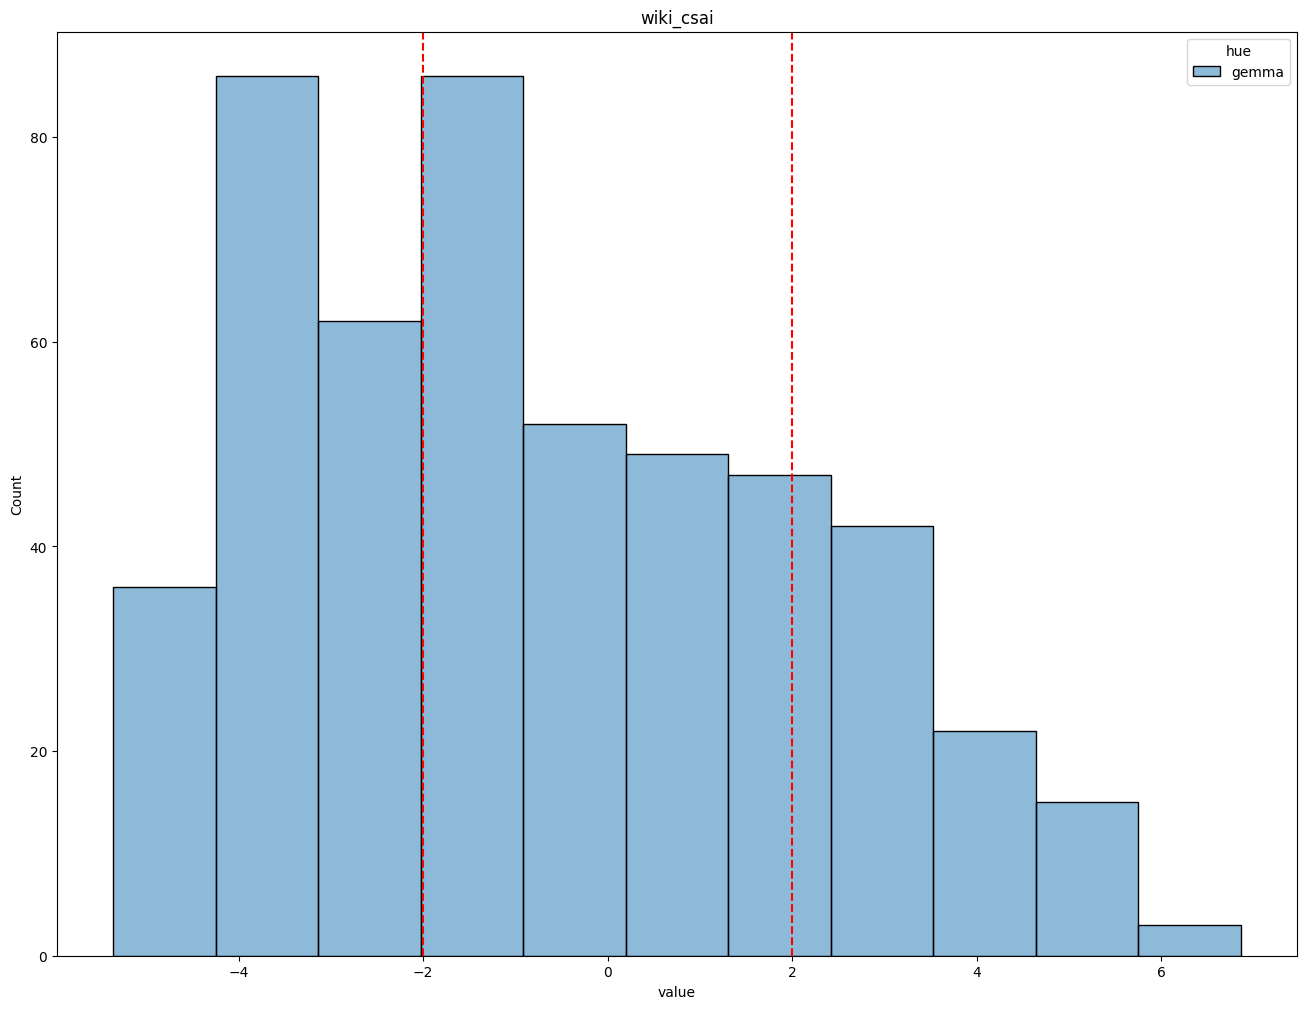

In [15]:
generated_texts = submission["generation"]
prompts = submission["prompt"]
new_p = []
new_t = []
for t, p in zip(generated_texts, prompts):
    if p.replace('"', "'") not in submission.prompt.tolist():
        continue
    new_p.append(p)
    new_t.append(t)

scores_generated = []
for g_text in generated_texts:
    with torch.no_grad():
        scores_generated.append(detector.get_score([g_text])[0].item())

visualize_df = pd.DataFrame({
    'value': scores_generated,
    'hue': ['gemma'] * len(scores_generated)
})

plt.figure(figsize=(16, 12))
sns.histplot(data=visualize_df, x='value', hue='hue')

plt.axvline(x=-2, color="red", linestyle="--")
plt.axvline(x=2, color="red", linestyle="--")

plt.title("wiki_csai")
plt.show()
